In [1]:
import os
import zipfile
import shutil
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import DistilBertModel, DistilBertTokenizer
from joblib import Parallel, delayed
import warnings

In [2]:
warnings.filterwarnings('ignore')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
# -----------------------------------
# Data Preparation Utilities
# -----------------------------------
def generate_audio_csv(path, out_csv='audio_data.csv'):
    if path.lower().endswith('.zip'):
        extract_dir = path[:-4]
        if os.path.exists(extract_dir): shutil.rmtree(extract_dir)
        with zipfile.ZipFile(path, 'r') as z: z.extractall(extract_dir)
        path = extract_dir
    emotion_map = {'01':'neutral','02':'calm','03':'happiness','04':'sadness',
                   '05':'anger','06':'fear','07':'disgust','08':'surprise'}
    entries=[]
    for root,_,files in os.walk(path):
        for f in files:
            if f.lower().endswith(('.wav','.mp3','.flac')):
                parts=f.split('-'); emo=emotion_map.get(parts[2]) if len(parts)>=3 else None
                if emo: entries.append([os.path.join(root,f), emo])
    df=pd.DataFrame(entries,columns=['file_path','emotion'])
    df.to_csv(out_csv,index=False)
    return pd.read_csv(out_csv)

In [4]:
# -----------------------------------
# Feature Extraction
# -----------------------------------
def extract_audio_features(path):
    try:
        y, sr = librosa.load(path, duration=3)
        mfcc = np.mean(librosa.feature.mfcc(y, sr, n_mfcc=13), axis=1)
        chroma = np.mean(librosa.feature.chroma_stft(y, sr), axis=1)
        return np.hstack([mfcc, chroma])
    except:
        return np.random.normal(0, 1, 25)

In [5]:
# -----------------------------------
# Model Definitions
# -----------------------------------
class AudioCNNLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, 3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(32, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.permute(0,2,1)
        _, (h, _) = self.lstm(x)
        h_cat = torch.cat((h[-2], h[-1]), dim=1)
        return h_cat, self.fc(h_cat)

In [6]:
class AudioAutoRegressive(nn.Module):
    def __init__(self, feature_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(feature_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, feature_dim)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [7]:
class TextClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        for p in self.bert.parameters(): p.requires_grad=False
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)
    def forward(self, ids, mask):
        out = self.bert(input_ids=ids, attention_mask=mask)
        cls = out.last_hidden_state[:,0]
        return cls, self.fc(cls)

In [8]:
class FusionModel(nn.Module):
    def __init__(self, adim, tdim, hidden_dim, num_classes, fusion_type='late'):
        super().__init__()
        self.fusion_type = fusion_type
        self.ah = nn.Linear(adim, num_classes)
        self.th = nn.Linear(tdim, num_classes)
        if fusion_type=='intermediate':
            self.inter = nn.Sequential(
                nn.Linear(adim+tdim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, num_classes)
            )
    def forward(self, a_feat, t_feat):
        a_logits = self.ah(a_feat)
        t_logits = self.th(t_feat)
        if self.fusion_type=='late': return (a_logits+t_logits)/2
        concat = torch.cat((a_feat, t_feat), dim=1)
        return self.inter(concat)

In [9]:
# -----------------------------------
# Dataset Wrappers
# -----------------------------------
class FeatureDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts, self.labels, self.tokenizer, self.max_len = texts, labels, tokenizer, max_len
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], padding='max_length', truncation=True,
                              max_length=self.max_len, return_tensors='pt')
        return enc['input_ids'].squeeze(0), enc['attention_mask'].squeeze(0), self.labels[idx]


In [10]:
# -----------------------------------
# Evaluator for Baselines & Visualizations
# -----------------------------------
class Evaluator:
    def __init__(self):
        self.scaler = StandardScaler()
        self.le = LabelEncoder()
        self.uniform = DummyClassifier(strategy='uniform', random_state=RANDOM_SEED)
        self.mfreq   = DummyClassifier(strategy='most_frequent', random_state=RANDOM_SEED)
        self.rf      = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
        self.lr      = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)

    def prepare(self, audio_df, text_df=None):
        feats = Parallel(n_jobs=os.cpu_count())(
            delayed(extract_audio_features)(p) for p in audio_df['file_path']
        )
        X = np.vstack(feats); y = audio_df['emotion'].values
        labels = list(y) + ([] if text_df is None else text_df['emotion'].values.tolist())
        self.le.fit(labels); y_enc = self.le.transform(y)
        X = self.scaler.fit_transform(X)
        Xa_tr, Xa_te, ya_tr, ya_te = train_test_split(X, y_enc, test_size=0.2,
                                                      stratify=y_enc, random_state=RANDOM_SEED)
        text_splits = None
        if text_df is not None:
            vec = TfidfVectorizer(max_features=1000)
            Xt = vec.fit_transform(text_df['text'].values)
            yt = self.le.transform(text_df['emotion'].values)
            Xt_tr, Xt_te, yt_tr, yt_te = train_test_split(Xt, yt, test_size=0.2,
                                                          stratify=yt, random_state=RANDOM_SEED)
            text_splits = (Xt_tr, Xt_te, yt_tr, yt_te)
        return (Xa_tr, Xa_te, ya_tr, ya_te), text_splits

    def evaluate_baselines(self, splits, text_splits=None):
        Xa_tr, Xa_te, ya_tr, ya_te = splits
        audio_labels = np.unique(ya_te)
        audio_names = self.le.inverse_transform(audio_labels)
        accuracies = {}
        for name, model in [('Random', self.uniform), ('MostFreq', self.mfreq), ('RandomForest', self.rf)]:
            model.fit(Xa_tr, ya_tr)
            yp = model.predict(Xa_te)
            accuracies[name] = accuracy_score(ya_te, yp)
            print(f"{name} Audio Accuracy: {accuracies[name]:.3f}")
            print(classification_report(ya_te, yp, labels=audio_labels, target_names=audio_names))
            cm = confusion_matrix(ya_te, yp, labels=audio_labels)
            plt.figure(figsize=(5,4)); plt.imshow(cm, cmap='Blues')
            plt.title(f"{name} Confusion Matrix")
            plt.xticks(range(len(audio_names)), audio_names, rotation=45)
            plt.yticks(range(len(audio_names)), audio_names)
            plt.colorbar(); plt.tight_layout(); plt.show()
        plt.figure(figsize=(5,3)); plt.bar(accuracies.keys(), accuracies.values())
        plt.title('Audio Baseline Accuracies'); plt.ylim(0,1); plt.show()
        if text_splits:
            Xt_tr, Xt_te, yt_tr, yt_te = text_splits
            text_labels = np.unique(yt_te)
            text_names = self.le.inverse_transform(text_labels)
            self.lr.fit(Xt_tr, yt_tr)
            yp = self.lr.predict(Xt_te)
            print(f"Text LR Accuracy: {accuracy_score(yt_te, yp):.3f}")
            print(classification_report(yt_te, yp, labels=text_labels, target_names=text_names))
            cm = confusion_matrix(yt_te, yp, labels=text_labels)
            plt.figure(figsize=(5,4)); plt.imshow(cm, cmap='Greens')
            plt.title('Text LR Confusion Matrix')
            plt.xticks(range(len(text_names)), text_names, rotation=45)
            plt.yticks(range(len(text_names)), text_names)
            plt.colorbar(); plt.tight_layout(); plt.show()

In [11]:
# -----------------------------------
# Training Loop: AudioCNNLSTM
# -----------------------------------
def train_audio_cnnlstm(splits, num_classes, label_names, epochs=5, lr=1e-3, device='cuda'):
    Xa_tr, Xa_te, ya_tr, ya_te = splits
    train_ds = FeatureDataset(Xa_tr, ya_tr)
    test_ds  = FeatureDataset(Xa_te, ya_te)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=32)
    model = AudioCNNLSTM(Xa_tr.shape[1], 64, num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    for ep in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            _, logits = model(x)
            loss = loss_fn(logits, y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
    model.eval()
    all_pred, all_true = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            _, logits = model(x)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_pred.extend(preds); all_true.extend(y.numpy())
    print('CNN-LSTM Audio Accuracy:', accuracy_score(all_true, all_pred))
    # Match classes present in test split
    audio_labels = sorted(set(all_true))
    audio_names  = [label_names[i] for i in audio_labels]
    print(classification_report(all_true, all_pred, labels=audio_labels, target_names=audio_names))
    cm = confusion_matrix(all_true, all_pred, labels=audio_labels)
    plt.figure(figsize=(5,4)); plt.imshow(cm, cmap='Blues')
    plt.title('CNN-LSTM Confusion Matrix')
    plt.xticks(range(len(audio_names)), audio_names, rotation=45)
    plt.yticks(range(len(audio_names)), audio_names)
    plt.colorbar(); plt.tight_layout(); plt.show()
    return model, test_loader

Random Audio Accuracy: 0.122
              precision    recall  f1-score   support

       anger       0.14      0.13      0.13        38
        calm       0.06      0.05      0.06        38
     disgust       0.12      0.11      0.11        38
        fear       0.11      0.13      0.12        39
   happiness       0.18      0.15      0.17        39
     neutral       0.09      0.16      0.11        19
     sadness       0.10      0.11      0.10        38
    surprise       0.18      0.15      0.17        39

    accuracy                           0.12       288
   macro avg       0.12      0.12      0.12       288
weighted avg       0.13      0.12      0.12       288



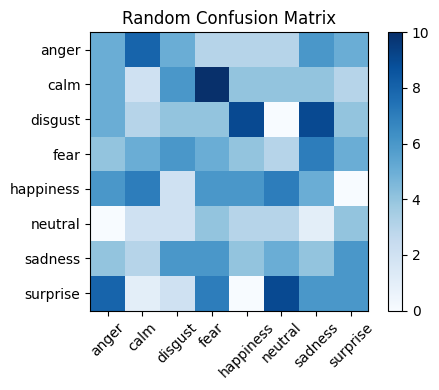

MostFreq Audio Accuracy: 0.132
              precision    recall  f1-score   support

       anger       0.13      1.00      0.23        38
        calm       0.00      0.00      0.00        38
     disgust       0.00      0.00      0.00        38
        fear       0.00      0.00      0.00        39
   happiness       0.00      0.00      0.00        39
     neutral       0.00      0.00      0.00        19
     sadness       0.00      0.00      0.00        38
    surprise       0.00      0.00      0.00        39

    accuracy                           0.13       288
   macro avg       0.02      0.12      0.03       288
weighted avg       0.02      0.13      0.03       288



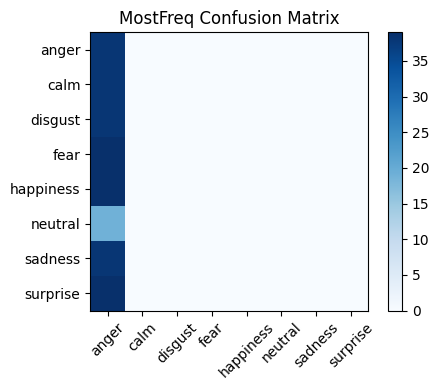

RandomForest Audio Accuracy: 0.128
              precision    recall  f1-score   support

       anger       0.14      0.18      0.16        38
        calm       0.14      0.16      0.15        38
     disgust       0.06      0.08      0.07        38
        fear       0.13      0.15      0.14        39
   happiness       0.09      0.08      0.08        39
     neutral       0.00      0.00      0.00        19
     sadness       0.14      0.13      0.14        38
    surprise       0.21      0.18      0.19        39

    accuracy                           0.13       288
   macro avg       0.11      0.12      0.12       288
weighted avg       0.12      0.13      0.12       288



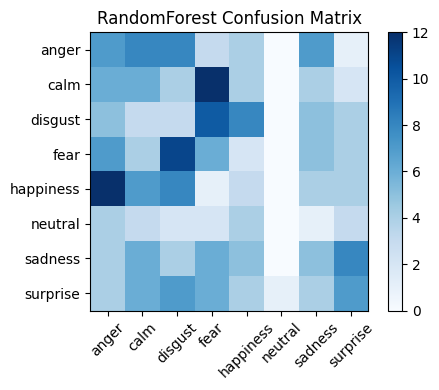

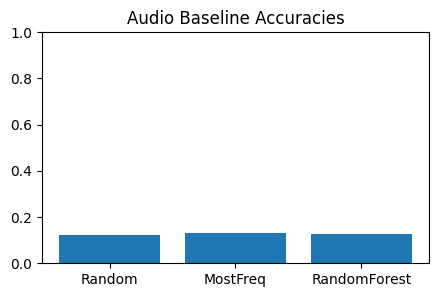

Text LR Accuracy: 0.333
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         3
     disgust       0.00      0.00      0.00         3
        fear       0.67      0.67      0.67         3
         joy       0.00      0.00      0.00         3
     neutral       1.00      0.33      0.50         3
     sadness       0.50      0.67      0.57         3
    surprise       1.00      0.67      0.80         3

    accuracy                           0.33        21
   macro avg       0.45      0.33      0.36        21
weighted avg       0.45      0.33      0.36        21



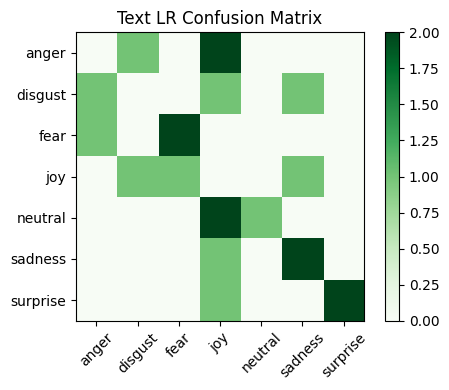

CNN-LSTM Audio Accuracy: 0.1388888888888889
              precision    recall  f1-score   support

       anger       0.15      0.63      0.24        38
        calm       0.11      0.11      0.11        38
     disgust       0.00      0.00      0.00        38
        fear       0.12      0.10      0.11        39
   happiness       0.13      0.05      0.07        39
     neutral       0.00      0.00      0.00        19
     sadness       0.14      0.16      0.15        38
    surprise       0.00      0.00      0.00        39

    accuracy                           0.14       288
   macro avg       0.08      0.13      0.09       288
weighted avg       0.09      0.14      0.09       288



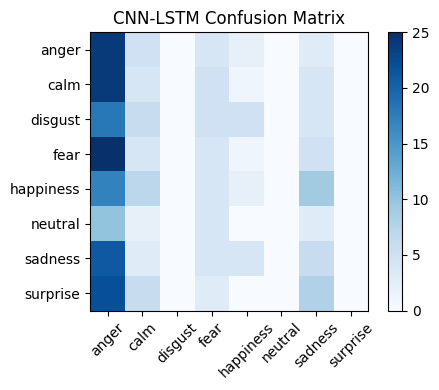

In [12]:
# -----------------------------------
# Main Execution
# -----------------------------------
if __name__ == '__main__':
    audio_df = generate_audio_csv('/content/Audio_Speech_Actors_01-24.zip')
    text_df = pd.read_csv('/content/emotion_dataset.csv') if os.path.exists('/content/emotion_dataset.csv') else None
    evaluator = Evaluator()
    audio_splits, text_splits = evaluator.prepare(audio_df, text_df)
    evaluator.evaluate_baselines(audio_splits, text_splits)
    # Deep audio training
    train_audio_cnnlstm(audio_splits, len(evaluator.le.classes_), evaluator.le.classes_)
    # Placeholders: train_audio_autoregressive, train_text_bert, train_fusion